In [ ]:
!kaggle datasets download -d shubhamgoel27/dermnet

Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 99% 1.71G/1.72G [00:26<00:00, 56.2MB/s]
100% 1.72G/1.72G [00:26<00:00, 70.3MB/s]


In [ ]:
!unzip dermnet.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  inflating: train/Seborrheic Keratoses and other Benign Tumors/keratoacanthom

In [ ]:
# Import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_dir = "/content/train"
test_dir = "/content/test"

# Hyperparameters
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 30
LEARNING_RATE = 0.001

# Data Transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine
import random



In [ ]:
# Define transforms for original and augmented data
original_transform = Compose([
    Resize((224, 224)),  # Resize images
    ToTensor(),  # Convert to PyTorch tensors
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])

In [ ]:
augmentation_transform = Compose([
    Resize((224, 224)),  # Resize images
    RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip
    RandomRotation(20),  # Random rotation
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random brightness/contrast adjustments
    RandomAffine(15, scale=(0.8, 1.2)),  # Random affine transformations
    ToTensor(),  # Convert PIL Image to PyTorch Tensor
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for ResNet
])


In [ ]:
# Create a custom dataset that combines original and augmented data
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, transform=None, augmentations=None):
        self.base_dataset = base_dataset
        self.transform = transform
        self.augmentations = augmentations

    def __len__(self):
        # Return double the dataset size to include augmented versions
        return 2 * len(self.base_dataset)

    def __getitem__(self, idx):
        # For indices in the first half, return original data
        if idx < len(self.base_dataset):
            img, label = self.base_dataset[idx]
            if self.transform:
                img = self.transform(img)
            return img, label
        # For indices in the second half, return augmented data
        else:
            img, label = self.base_dataset[idx - len(self.base_dataset)]
            if self.augmentations:
                img = self.augmentations(img)
            return img, label

In [ ]:
# prompt: only keep the classes in classes, delete other folders from /content/train and /content/test

import os
import shutil

def remove_folders(root_dir, classes_to_keep):
    for item in os.listdir(root_dir):
        item_path = os.path.join(root_dir, item)
        if os.path.isdir(item_path) and item not in classes_to_keep:
            print(f"Removing directory: {item_path}")
            shutil.rmtree(item_path)

# Specify the classes to keep
classes_to_keep = [
    'Melanoma Skin Cancer Nevi and Moles',
    'Eczema Photos',
    'Acne and Rosacea Photos',
    'Herpes HPV and other STDs Photos',
    'Exanthems and Drug Eruptions',
    'Nail Fungus and other Nail Disease',
    'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
]


# Clean the train directory
remove_folders("/content/train", classes_to_keep)

# Clean the test directory
remove_folders("/content/test", classes_to_keep)

In [ ]:
# Load the original dataset
train_dir = "/content/train"
train_dataset = ImageFolder(root=train_dir)



In [ ]:
# Wrap the dataset with the AugmentedDataset class
augmented_train_dataset = AugmentedDataset(
    base_dataset=train_dataset,
    transform=original_transform,
    augmentations=augmentation_transform
)

In [ ]:
# DataLoader
train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True, num_workers=2)

# Test DataLoader remains unchanged
test_dir = "/content/test"
test_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_dataset = ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check the number of samples
print(f"Original training samples: {len(train_dataset)}")
print(f"Augmented training samples: {len(augmented_train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Original training samples: 5536
Augmented training samples: 11072
Test samples: 1489


In [ ]:
# Load Pretrained ResNet34 Model
model = torchvision.models.resnet34(pretrained=True)

# Modify the last layer for the dataset's number of classes
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to device


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s]


In [ ]:
model = model.to(device)

# Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar

best_accuracy = 0.0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Add tqdm for progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch [{epoch+1}/{EPOCHS}]")

    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update tqdm with the current loss
        loop.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

    # Validate the Model
    model.eval()
    correct = 0
    total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)  # Calculate validation loss
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_running_loss / len(test_loader)
    accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%")

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_resnet18_model.pth")
        print("Best model saved!")



Epoch [1/30]: 100%|██████████| 346/346 [01:55<00:00,  2.98it/s, loss=1.24]


Epoch [1/30], Loss: 1.4110, Training Accuracy: 49.69%
Validation Loss: 1.3102, Validation Accuracy: 53.59%
Best model saved!


Epoch [2/30]: 100%|██████████| 346/346 [01:52<00:00,  3.07it/s, loss=1.38]

Epoch [2/30], Loss: 1.0989, Training Accuracy: 61.78%


Validation Loss: 1.1593, Validation Accuracy: 56.95%
Best model saved!


Epoch [3/30]: 100%|██████████| 346/346 [01:56<00:00,  2.97it/s, loss=1.02]

Epoch [3/30], Loss: 0.9550, Training Accuracy: 66.59%


Validation Loss: 0.9438, Validation Accuracy: 66.82%
Best model saved!


Epoch [4/30]: 100%|██████████| 346/346 [01:56<00:00,  2.98it/s, loss=0.798]

Epoch [4/30], Loss: 0.8511, Training Accuracy: 70.60%


Validation Loss: 0.8947, Validation Accuracy: 71.46%
Best model saved!


Epoch [5/30]: 100%|██████████| 346/346 [01:57<00:00,  2.95it/s, loss=0.632]

Epoch [5/30], Loss: 0.7662, Training Accuracy: 73.68%


Validation Loss: 0.7597, Validation Accuracy: 74.01%
Best model saved!


Epoch [6/30]: 100%|██████████| 346/346 [02:00<00:00,  2.88it/s, loss=0.631]

Epoch [6/30], Loss: 0.6889, Training Accuracy: 76.31%


Validation Loss: 0.8791, Validation Accuracy: 71.93%


Epoch [7/30]: 100%|██████████| 346/346 [01:57<00:00,  2.93it/s, loss=0.474]

Epoch [7/30], Loss: 0.6043, Training Accuracy: 79.19%


Validation Loss: 0.7563, Validation Accuracy: 74.35%
Best model saved!


Epoch [8/30]: 100%|██████████| 346/346 [01:56<00:00,  2.98it/s, loss=0.474]

Epoch [8/30], Loss: 0.5610, Training Accuracy: 80.76%


Validation Loss: 0.7669, Validation Accuracy: 74.82%
Best model saved!


Epoch [9/30]: 100%|██████████| 346/346 [01:54<00:00,  3.01it/s, loss=0.489]

Epoch [9/30], Loss: 0.5019, Training Accuracy: 82.51%


Validation Loss: 0.7785, Validation Accuracy: 74.14%


Epoch [10/30]: 100%|██████████| 346/346 [01:52<00:00,  3.08it/s, loss=0.483]

Epoch [10/30], Loss: 0.4563, Training Accuracy: 84.33%


Validation Loss: 0.9556, Validation Accuracy: 72.20%


Epoch [11/30]: 100%|██████████| 346/346 [01:53<00:00,  3.06it/s, loss=0.551]

Epoch [11/30], Loss: 0.4181, Training Accuracy: 85.63%


Validation Loss: 0.7855, Validation Accuracy: 75.42%
Best model saved!


Epoch [12/30]: 100%|██████████| 346/346 [01:53<00:00,  3.04it/s, loss=0.677]

Epoch [12/30], Loss: 0.3703, Training Accuracy: 86.93%


Validation Loss: 0.7598, Validation Accuracy: 77.23%
Best model saved!


Epoch [13/30]: 100%|██████████| 346/346 [01:55<00:00,  2.99it/s, loss=0.411]

Epoch [13/30], Loss: 0.3497, Training Accuracy: 88.31%


Validation Loss: 0.7167, Validation Accuracy: 78.78%
Best model saved!


Epoch [14/30]: 100%|██████████| 346/346 [01:51<00:00,  3.09it/s, loss=0.123]

Epoch [14/30], Loss: 0.3280, Training Accuracy: 89.05%


Validation Loss: 0.6654, Validation Accuracy: 81.33%
Best model saved!


Epoch [15/30]: 100%|██████████| 346/346 [01:52<00:00,  3.07it/s, loss=0.19]

Epoch [15/30], Loss: 0.3099, Training Accuracy: 89.19%


Validation Loss: 0.6657, Validation Accuracy: 82.20%
Best model saved!


Epoch [16/30]: 100%|██████████| 346/346 [01:54<00:00,  3.02it/s, loss=0.612]

Epoch [16/30], Loss: 0.2781, Training Accuracy: 90.65%


Validation Loss: 0.7625, Validation Accuracy: 80.93%


Epoch [17/30]: 100%|██████████| 346/346 [01:51<00:00,  3.11it/s, loss=0.52]

Epoch [17/30], Loss: 0.2594, Training Accuracy: 91.21%


Validation Loss: 0.7794, Validation Accuracy: 81.33%


Epoch [18/30]: 100%|██████████| 346/346 [01:52<00:00,  3.07it/s, loss=0.124]

Epoch [18/30], Loss: 0.2426, Training Accuracy: 91.68%


Validation Loss: 0.7247, Validation Accuracy: 81.60%


Epoch [19/30]: 100%|██████████| 346/346 [01:53<00:00,  3.04it/s, loss=0.493]

Epoch [19/30], Loss: 0.2381, Training Accuracy: 92.00%


Validation Loss: 0.8341, Validation Accuracy: 78.78%


Epoch [20/30]: 100%|██████████| 346/346 [01:54<00:00,  3.03it/s, loss=0.121]

Epoch [20/30], Loss: 0.2198, Training Accuracy: 92.42%


Validation Loss: 0.8126, Validation Accuracy: 79.85%


Epoch [21/30]: 100%|██████████| 346/346 [01:52<00:00,  3.08it/s, loss=0.553]

Epoch [21/30], Loss: 0.2293, Training Accuracy: 92.11%


Validation Loss: 0.8880, Validation Accuracy: 78.98%


Epoch [22/30]: 100%|██████████| 346/346 [01:53<00:00,  3.04it/s, loss=0.169]

Epoch [22/30], Loss: 0.2188, Training Accuracy: 92.78%


Validation Loss: 0.7351, Validation Accuracy: 82.00%


Epoch [23/30]: 100%|██████████| 346/346 [01:53<00:00,  3.04it/s, loss=0.0621]

Epoch [23/30], Loss: 0.1996, Training Accuracy: 93.34%


Validation Loss: 0.8117, Validation Accuracy: 81.33%


Epoch [24/30]: 100%|██████████| 346/346 [01:52<00:00,  3.08it/s, loss=0.274]

Epoch [24/30], Loss: 0.1865, Training Accuracy: 93.70%


Validation Loss: 0.7256, Validation Accuracy: 81.80%


Epoch [25/30]: 100%|██████████| 346/346 [01:55<00:00,  3.01it/s, loss=0.161]

Epoch [25/30], Loss: 0.1896, Training Accuracy: 93.27%


KeyboardInterrupt: 

In [ ]:
num_classes

7

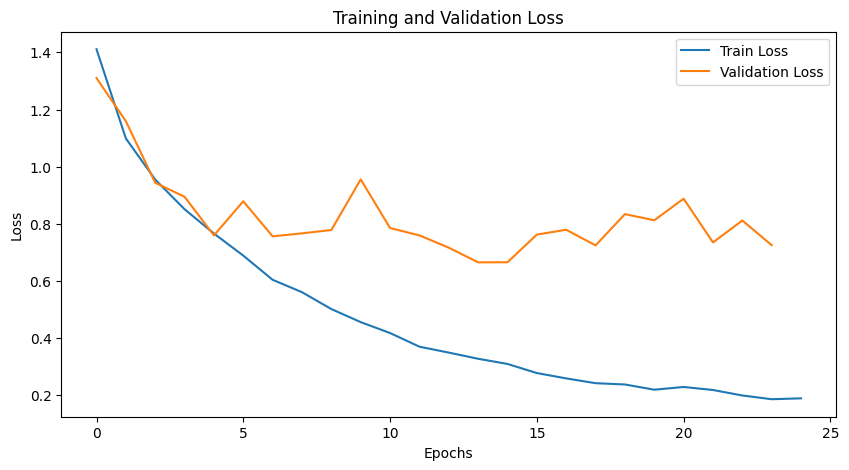

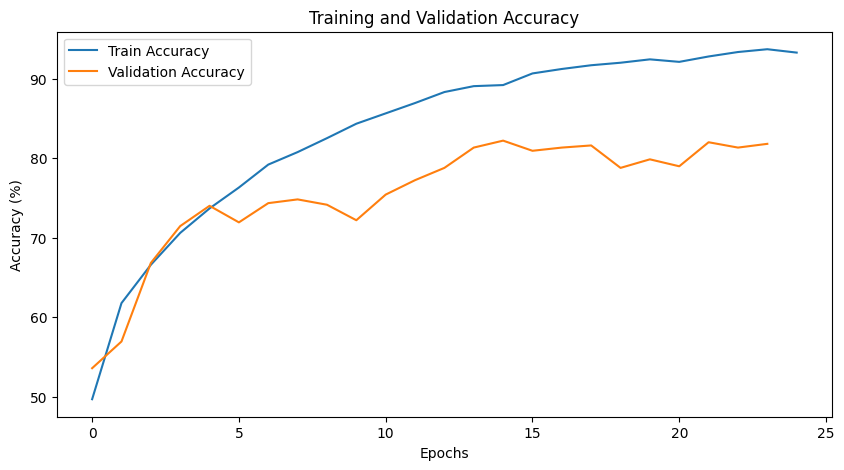

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

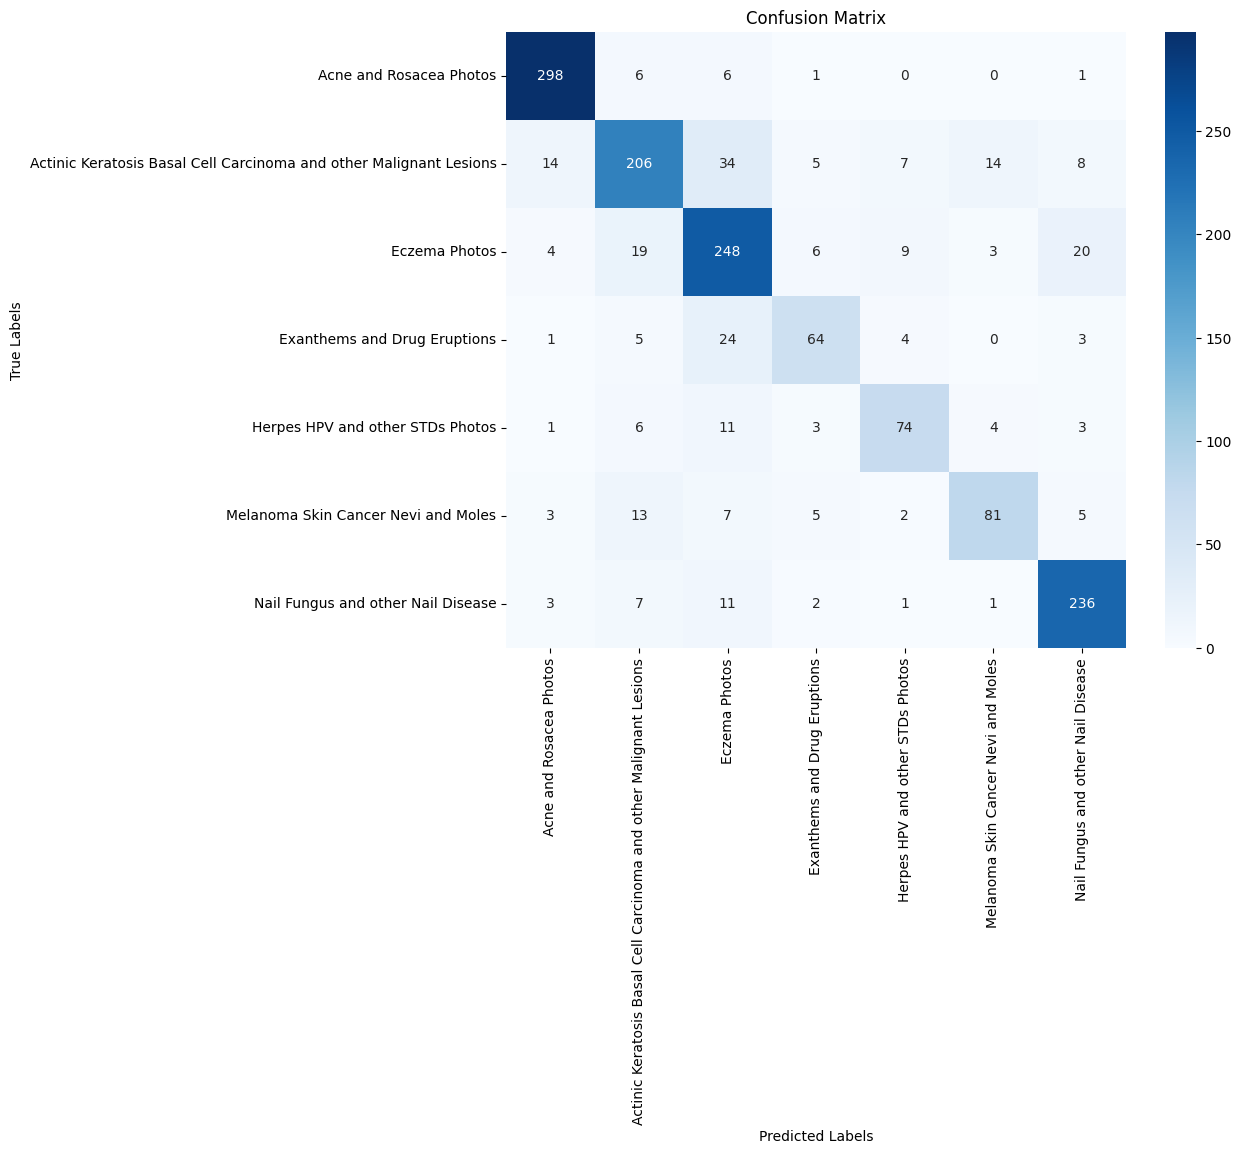

In [ ]:
# prompt: make confusion matrix

# Get predictions for the test set
y_pred = []
y_true = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

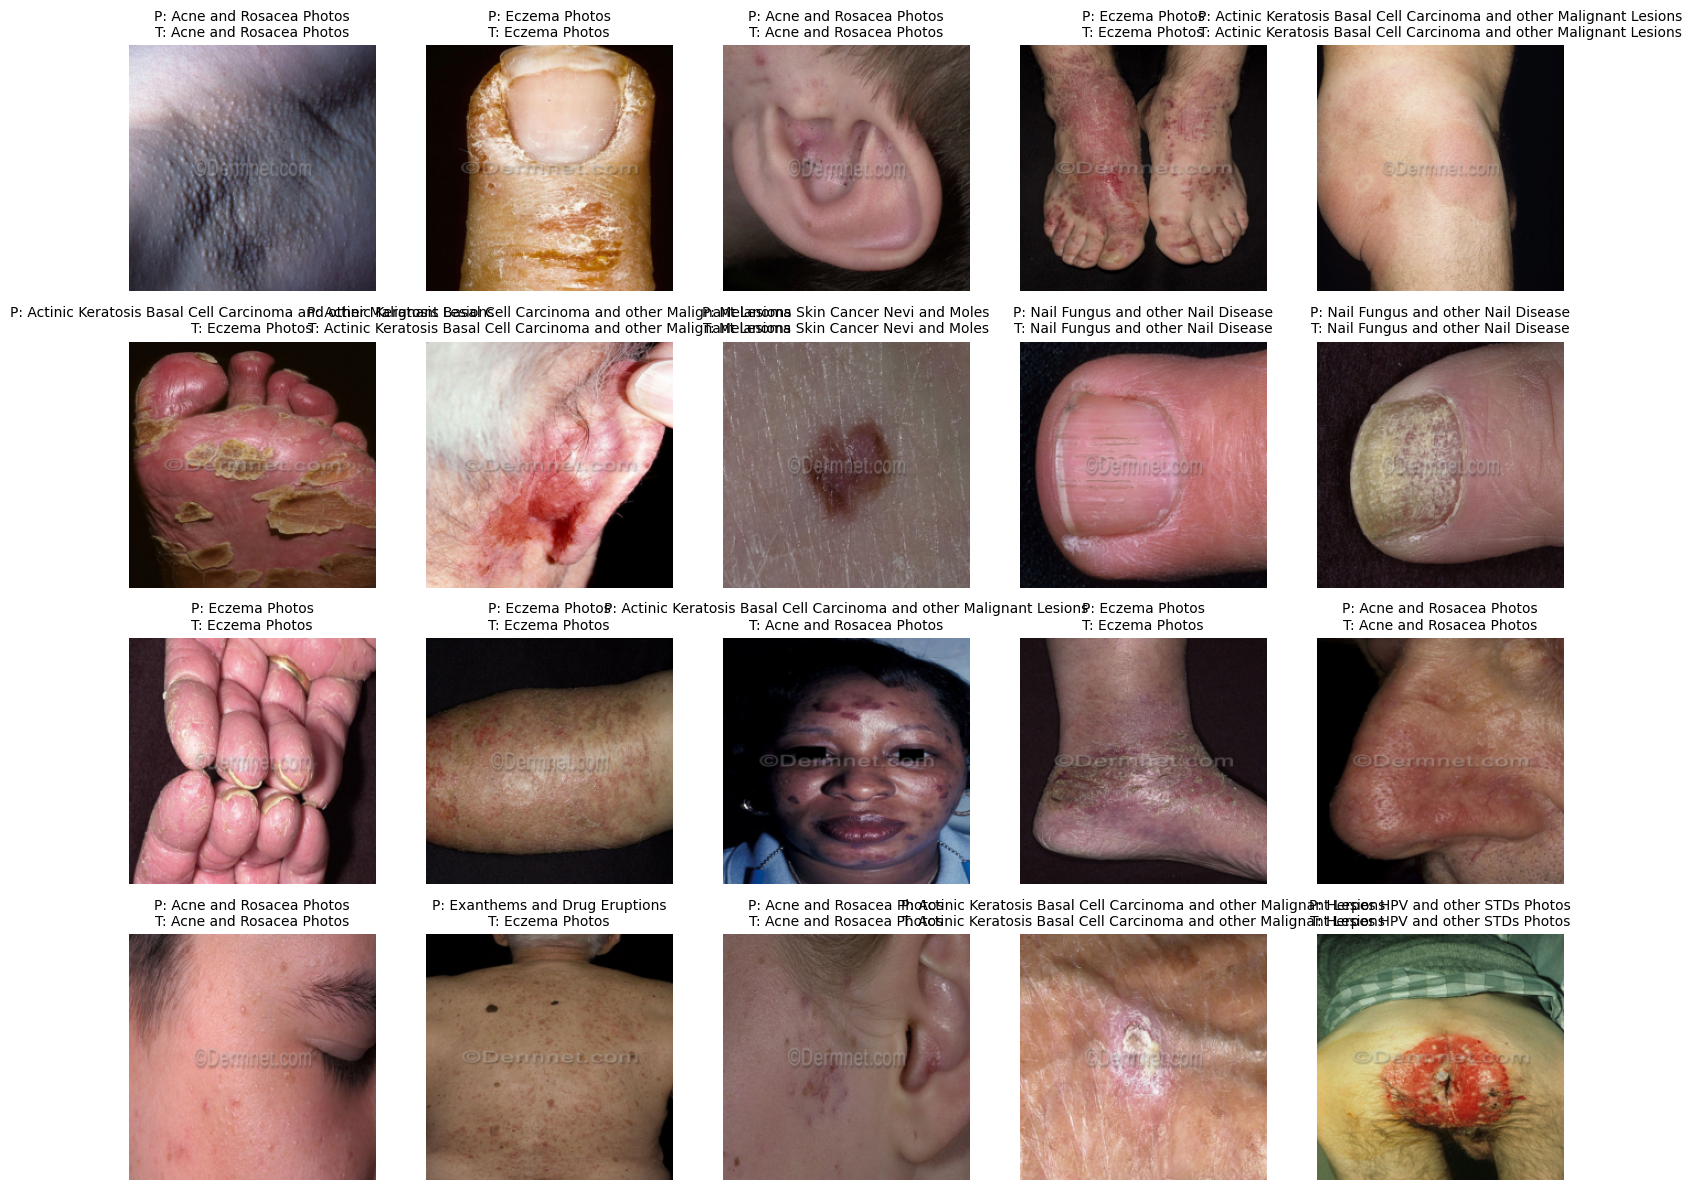

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader

# Assuming 'test_loader', 'model', 'device', and 'train_dataset' are defined as in your code

test_loader_viz = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

def visualize_predictions(test_loader, model, device, train_dataset, num_images=10):
    """
    Visualize predictions of the model alongside the true labels in a grid format.

    Args:
    test_loader (DataLoader): DataLoader for the test set.
    model (nn.Module): Trained model.
    device (torch.device): Device to perform computation on (CPU or GPU).
    train_dataset (Dataset): The training dataset containing class names.
    num_images (int): Number of images to display.
    """
    model.eval()
    images_so_far = 0
    nrows = int(np.ceil(num_images / 5))  # 5 images per row
    ncols = min(num_images, 5)  # Total columns limited to 5

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 3))
    axes = axes.flatten()  # Flatten to easily iterate over

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    break

                ax = axes[images_so_far]
                ax.axis('off')
                ax.set_title(f'P: {train_dataset.classes[preds[j]]}\nT: {train_dataset.classes[labels[j]]}', fontsize=10)
                imshow(inputs.cpu().data[j], ax)
                images_so_far += 1

            if images_so_far == num_images:
                break

def imshow(inp, ax):
    """Imshow for Tensor, used for displaying an image on a given axis."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Unnormalize
    inp = np.clip(inp, 0, 1)  # Clip to [0, 1] range
    ax.imshow(inp)


# Visualize predictions in a 2D grid
visualize_predictions(test_loader_viz, model, device, train_dataset, num_images=20)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: write code to read image.png and give the prediction

from PIL import Image
import torchvision.transforms as transforms

# Load the saved model
model = torchvision.models.resnet34(pretrained=False)
num_classes = len(train_dataset.classes)  # Assuming train_dataset is defined in the previous code
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("best_resnet18_model.pth"))
model = model.to(device)
model.eval()

# Define the image transformations
# transform = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


# Load and preprocess the image
image = Image.open('/content/eczema3.jpg').convert("RGB")
image = test_transform(image).unsqueeze(0).to(device)

# Make the prediction
with torch.no_grad():
  outputs = model(image)
  scores = zip(train_dataset.classes, outputs[0].tolist())
  print(f"Scores: {dict(scores)}")
  _, predicted = torch.max(outputs, 1)

# Print the predicted class
print(f"Predicted class: {train_dataset.classes[predicted.item()]}")

<ipython-input-43-389286df6196>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet18_model.pth"))


Scores: {'Acne and Rosacea Photos': -7.3538312911987305, 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': -0.4956985116004944, 'Eczema Photos': 0.19290471076965332, 'Exanthems and Drug Eruptions': -2.501516580581665, 'Herpes HPV and other STDs Photos': -5.049741744995117, 'Melanoma Skin Cancer Nevi and Moles': -3.1951546669006348, 'Nail Fungus and other Nail Disease': 5.522750377655029}
Predicted class: Nail Fungus and other Nail Disease


In [ ]:
# prompt: write a flask app that reads the pth file loads the model and takes image as input and returns the output as json

from flask import Flask, request, jsonify
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import io
import json

app = Flask(__name__)

# Load the model
model = models.resnet34(pretrained=False)
num_classes = 6  # Replace with the actual number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load("best_resnet18_model.pth"))
model.eval()

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Class labels (replace with your actual class labels)
class_labels = [
    'Hair Loss Photos Alopecia and other Hair Diseases',
    'Scabies Lyme Disease and other Infestations and Bites',
    'Melanoma Skin Cancer Nevi and Moles',
    'Eczema Photos',
    'Acne and Rosacea Photos',
    'Psoriasis pictures Lichen Planus and related diseases',
]


@app.route('/predict', methods=['POST'])
def predict():
    if 'image' not in request.files:
        return jsonify({'error': 'No image provided'}), 400

    image_file = request.files['image']
    image_bytes = image_file.read()

    try:
        image = Image.open(io.BytesIO(image_bytes))
        image = transform(image).unsqueeze(0)

        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
            predicted_class = class_labels[predicted.item()]
            scores = {label: score for label, score in zip(class_labels, outputs[0].tolist())}


        return jsonify({'predicted_class': predicted_class, 'scores': scores})

    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)